In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})


In [2]:
kvec = [1e-1, 1, 10]
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
          'N_ncdm':1, 'm_ncdm':10, 'gauge':'synchronous'})
cosmo.compute()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
65.4957555323583


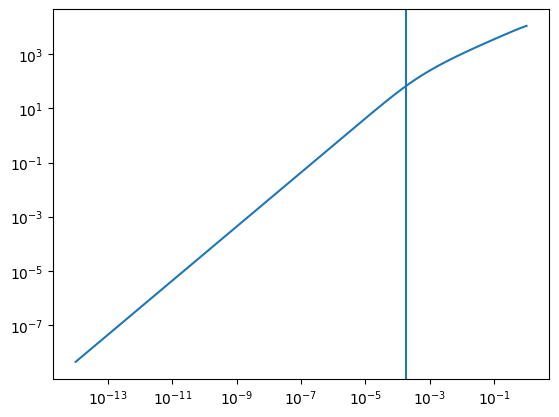

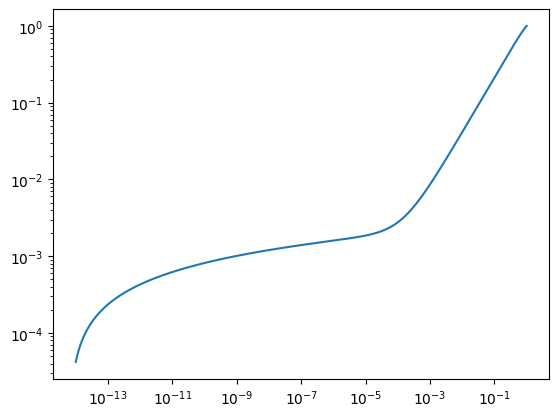

In [3]:
bg = cosmo.get_background()
print(bg.keys())
a = 1/(1 + bg['z'])
tau = bg['conf. time [Mpc]']
plt.loglog(a, tau)
a_eq = cosmo.get_current_derived_parameters(['a_eq'])['a_eq']
plt.axvline(a_eq)
print(np.interp(a_eq, a, tau))

plt.figure()
plt.loglog(a, bg['gr.fac. D'])


[2.29932638e+22 2.25042310e+22 2.20255992e+22 ... 2.37498824e-04
 2.35473075e-04 2.33494867e-04]


dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])


Text(0.5, 1.0, 'k = 1 1/Mpc')

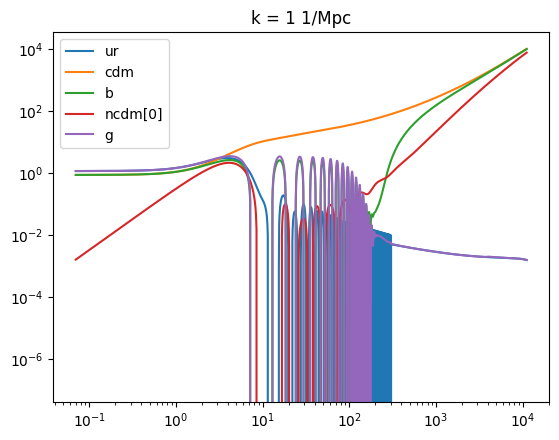

In [5]:
pts = cosmo.get_perturbations()['scalar']
index_k = 1
pts0 = pts[index_k]
pts0['a']
print(pts0.keys())
for species in ['ur', 'cdm', 'b', 'ncdm[0]', 'g']:
    delta = pts0['delta_' + species]
    plt.loglog(pts0['tau [Mpc]'], -delta, label=species)
plt.legend()
plt.title(f'k = {kvec[index_k]} 1/Mpc')

In [6]:
# all output er i newtonian gauge af historiske årsager du kan overveje at udkommetnere gaugetransformation i koden senere.

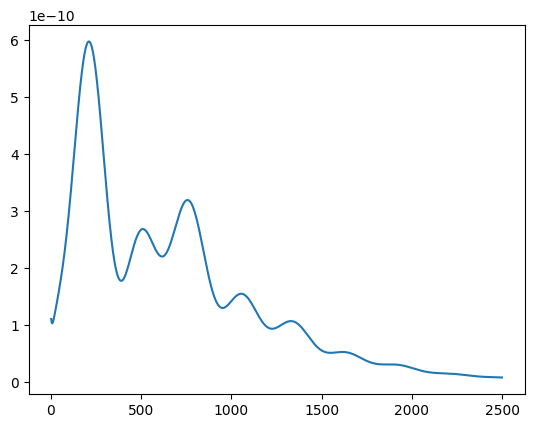

In [7]:
cl_lensed = cosmo.lensed_cl()
l = cl_lensed['ell'][2:]
factor = l*(l + 1)/(2*np.pi)
plt.plot(l, factor*cl_lensed['tt'][2:])

Så det er rent kaos herfra

$\ddot{D} + H\dot{D} = \frac{3}{2} H^2 \Omega_m a^2 D$

In [8]:
a0 = pts0["a"][0]
aend = 1

Omega_lambda = 0.7 - 2 * 1e-5
Omega_M = 0.3- 2 * 1e-5
Omega_R = 4 * 1e-5
H0 = 70 / (3*1e5) # i 1/Mpc

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])#,t_eval=a2) 

tau =sol1.y[0]
print(tau[0],tau[-1])
print(tau0)
print(a0)

0.1090938390410027 13986.528539432324
0.1090938390410027
1.60993004695305e-07


In [9]:
a0 = pts0["a"][0]
aend = 1

Omega_lambda = 0.7 - 2 * 1e-5
Omega_M = 0.3- 2 * 1e-5
Omega_R = 4 * 1e-5
H0 = 70 / (3*1e5) # i 1/Mpc

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])#,t_eval=a2) 

tau =sol1.y[0]
#print(tau[0],tau[-1])
#print(tau0)
#print(a0)

C = 0.31
k = 1
cs = 0.01
R_nu = 0

psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 = delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)
#,delta_nu_0,theta_nu_0])


def f1(t,y):
    # kun cdm så cs = 0
    # her er t = tau
    a = y[0]
    D = y[1]
    D_dt = y[2]
    delta_cb = y[3]
    theta_cb = y[4]
    delta_nu = y[4]
    theta_nu = y[6]
    #print(t)
    a_dt = a * a * H(a)
    Omega_M_reel = Omega_M / ( a**3 * Omega_lambda + Omega_M + Omega_R / a)
    nabla2phi = ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb+delta_nu) / (a)
    
    D2_dt2 = - a * H(a) * D_dt +  ((3 / 2) * H0 * H0 * Omega_M * D / (a))
    
    delta_cb_dt = - theta_cb
    
    theta_cb_dt = -  a * H(a) * theta_cb - nabla2phi 
    
    delta_nu_dt = - theta_nu
    
    theta_nu_dt = -  a * H(a) * theta_nu - nabla2phi - k*k * (cs*cs ) * delta_nu
    
    return [a_dt,D_dt,D2_dt2,delta_cb_dt,theta_cb_dt,delta_nu_dt,theta_nu_dt]


t_start = tau[0]
t_end = tau[-1]
tau_span = np.array([t_start,t_end])
#print(tau_span)
D0 = delta_cb_0
D1 = - theta_cb_0 - theta_nu_0
y0 = [a0,D0,D1,delta_cb_0,theta_cb_0,delta_nu_0,theta_nu_0]
# y0 = 
y0 = [a0,D0,D1,-theta_cb_0, -  a0 * H(a0) * theta_cb_0 - ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb_0+delta_nu_0) / (a0)  ,
      - theta_nu_0,-  a0 * H(a0) * theta_nu_0 -( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb_0+delta_nu_0) / (a0) ]

#print(y0)
tau_eval = np.linspace(t_start,t_end,10000)
sol = sc.solve_ivp(f1,t_span=tau_span,y0 = y0)#,t_eval=tau_eval)
tau = sol.t
#print(sol.t[-1])
a = sol.y[0]
D = sol.y[1]
D_dt = sol.y[2]
delta_cdm = sol.y[3]
delta_nu = sol.y[5]
theta_cdm = sol.y[4]
theta_nu = sol.y[6]
delta_cb = delta_cdm
theta_cb = theta_cdm
print(pts0['delta_' + "cdm"][-3:])
print(delta_cb[-3:])

[ -9959.24781381 -10241.92784289 -10421.18513403]
[-189.37457207 -385.01422598 -587.81685535]


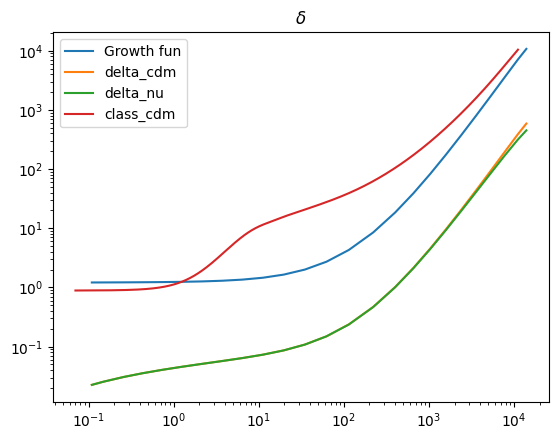

In [10]:

plt.loglog(tau,-1.1*D, label="Growth fun")
plt.loglog(tau,-delta_cb,label="delta_cdm")
plt.loglog(tau,-delta_nu,label="delta_nu")
plt.loglog(pts0['tau [Mpc]'],-pts0['delta_' + "cdm"],label="class_cdm")
#plt.loglog(tau,-( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb+delta_nu) / (a))
plt.title(r"$\delta$")
plt.legend()

Text(0, 0.5, 'delta')

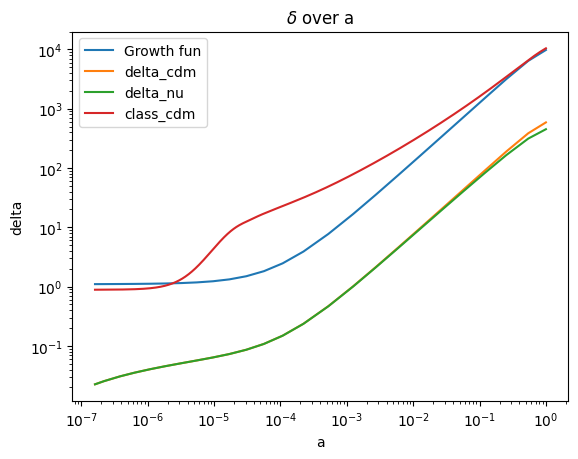

In [11]:
#print(a)
#print(D_dt)
#print(D)
#theta = - D_dt / D  * delta_cb_0
plt.loglog(a,-1*D, label="Growth fun")
plt.loglog(a,-delta_cb,label="delta_cdm")
plt.loglog(a,-delta_nu,label="delta_nu")
plt.loglog(pts0['a'],-pts0['delta_' + "cdm"],label="class_cdm")
#plt.plot(tau,-1.1*D, label="Growth fun")
#print(a)
plt.title(r"$\delta$ over a")
plt.legend()
plt.xlabel("a")
plt.ylabel("delta")


Text(0.5, 0, 'a')

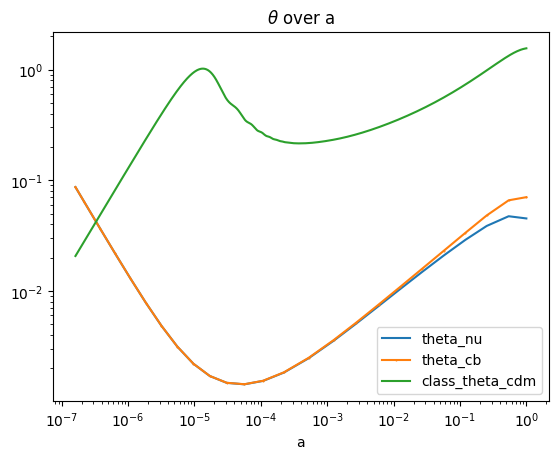

In [12]:
plt.title(r"$\theta$ over a")


plt.loglog(a,theta_nu,label="theta_nu",markersize=12)
plt.loglog(a,theta_cb,label="theta_cb",marker=".",markersize =.9051)
#plt.plot()
plt.loglog(pts0['a'],pts0['theta_' + "cdm"],label="class_theta_cdm")
plt.legend()
plt.xlabel("a")

In [13]:
print(len(D))
print(len(a))
print(len(tau))
print(len)
#pts0['a'][0]
print(delta_cb_0)

25
25
25
<built-in function len>
-1.1022222222222222


Forkert
Lad værd med at kigge
jeg skal lige rette det her til det rigtige
$\frac{d\delta}{dt} = -\frac{\theta}{a}\quad a d\tau = dt\\
	\frac{d\delta}{ad\tau} = -\frac{\theta}{a}\quad
	\frac{d\delta}{d\tau} = -\theta\\
	\frac{d\theta}{dt}+H\theta=-1/a \nabla^2 \psi\quad H= \frac{da}{adt}=\frac{da}{a^2dt} = \frac{1}{a}H
	\\
	 \frac{d\theta}{ad\tau}+\frac{1}{a}H\theta=-1/a \nabla^2 \psi \quad  \frac{d\theta}{d\tau} + H\theta=- \nabla^2 \psi\\
	\frac{d^2 \delta}{d^2\tau} + H \frac{d\delta}{d\tau} = \nabla^2 \psi = \frac{3}{2} H^2 \Omega a^2 \delta\quad \delta(\tau,x) = D(\tau) \hat{\delta}(x)\\
	\ddot{D} + H\dot{D} = \frac{3}{2} H^2 \Omega a^2 D$
    Men det sidste er rigtigt
    $
    \ddot{D} + a H \dot{D} = \frac{3}{2} H_0 ^2 \frac{\Omega_0}{a} D$

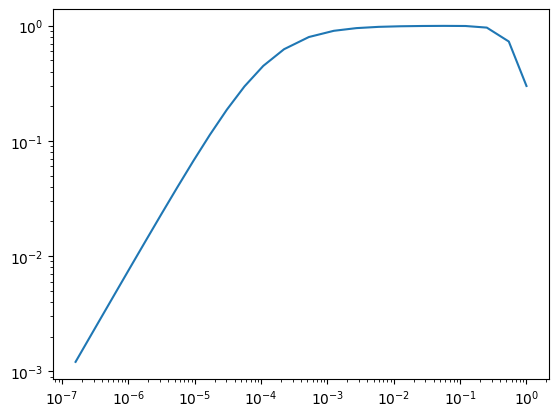

In [14]:
Omega_M_reel = Omega_M / ( a**3 * Omega_lambda + Omega_M + Omega_R / a)
plt.loglog(a,Omega_M_reel)

[ -9959.24781381 -10241.92784289 -10421.18513403]
Done


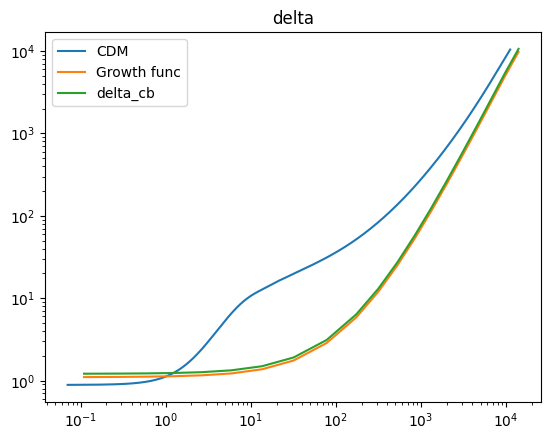

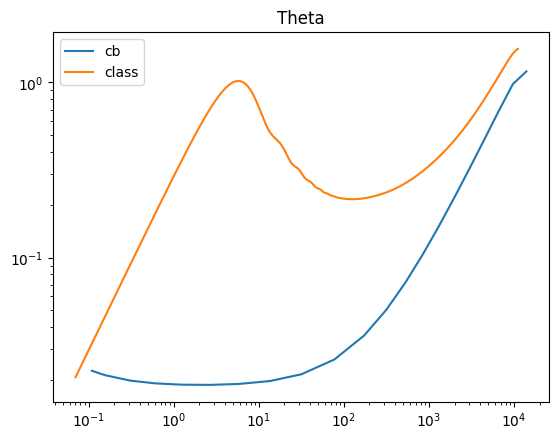

In [84]:
a0 = pts0["a"][0]
aend = 1

Omega_lambda = 0.7 - 2 * 1e-5
Omega_M = 0.3- 2 * 1e-5
Omega_R = 4 * 1e-5
H0 = 70 / (3*1e5) # i 1/Mpc

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])#,t_eval=a2) 

tau =sol1.y[0]
#print(tau[0],tau[-1])
#print(tau0)
#print(a0)

C = 0.31
k = 1
cs = 0.01
R_nu = 0

psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 = delta_gamma
delta_cb_0 = 4/3 * delta_gamma
phi = psi * (1 + R_nu)
#,delta_nu_0,theta_nu_0])


def f1(t,y):
    # kun cdm så cs = 0
    # her er t = tau
    a = y[0]
    D = y[1]
    D_dt = y[2]
    delta_cb = y[3]
    theta_cb = y[4]
    #delta_nu = y[4]
    #theta_nu = y[6]
    #print(t)
    a_dt = a * a * H(a)
        
    Omega_M_reel = Omega_M / ( a**3 * Omega_lambda + Omega_M + Omega_R / a)
    
    nabla2phi = ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb) / a # + delta_nu
    
    D2_dt2 = +  ((3 / 2) * H0 * H0 * Omega_M * D / a) - a * H(a) * D_dt 
    
    # PROBLEMET LIGGER HER 
    # - a * H(a) * D_dt 
    
    
    delta_cb_dt = - theta_cb
    
    theta_cb_dt = -  a * H(a) * theta_cb - nabla2phi 
    
    #delta_nu_dt = - theta_nu
    
    #theta_nu_dt = -  a * H(a) * theta_nu - nabla2phi - k*k * (cs*cs ) * delta_nu
    
    return [a_dt,D_dt,D2_dt2,delta_cb_dt,theta_cb_dt]#,delta_nu_dt,theta_nu_dt]


t_start = tau[0]
t_end = tau[-1]
tau_span = np.array([t_start,t_end])
#print(tau_span)
D0 = delta_cb_0
D1 = - theta_cb_0   - theta_nu_0

y0 = [a0,D0,D1,delta_cb_0,theta_cb_0,delta_nu_0,theta_nu_0]
# y0 = 
y0 = [a0,D0,D1]
#y0 = [a0,D0,D1,-theta_cb_0,-a0*H(a0)*theta_cb_0-(3/2)*H0*H0*Omega_M*(delta_cb_0+delta_nu_0)/a0,-theta_nu_0,-a0*H(a0)*theta_nu_0 -( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb_0+delta_nu_0) / (a0) ]
y0 = [a0,D0,D1,delta_cb_0,theta_cb_0]#,delta_nu_0,theta_nu_0]

#print(y0)
tau_eval = np.linspace(t_start,t_end,10000)
sol = sc.solve_ivp(f1,t_span=tau_span,y0 = y0)#,t_eval=tau_eval)
tau = sol.t
#print(sol.t[-1])
a = sol.y[0]
D = sol.y[1]
D_dt = sol.y[2]
delta_cdm = sol.y[3]
#delta_nu = sol.y[5]
theta_cdm = sol.y[4]
#theta_nu = sol.y[6]
delta_cb = delta_cdm
theta_cb = theta_cdm
print(pts0['delta_' + "cdm"][-3:])
plt.loglog(pts0["tau [Mpc]"],-pts0['delta_' + "cdm"],label="CDM")
#print(delta_cb[-3:])
print("Done")
#plt.loglog(tau,D,label="Growth func")
plt.loglog(tau,-D,label="Growth func")
plt.loglog(tau,-1.1*delta_cdm,label="delta_cb")
#plt.loglog(tau,-delta_nu)
plt.legend()
plt.title("delta")
plt.figure(1341)
plt.loglog(tau,theta_cdm,label="cb")
#plt.loglog(tau,theta_nu)
plt.loglog(pts0["tau [Mpc]"],pts0['theta_' + "cdm"],label="class")
plt.title("Theta")
plt.legend()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


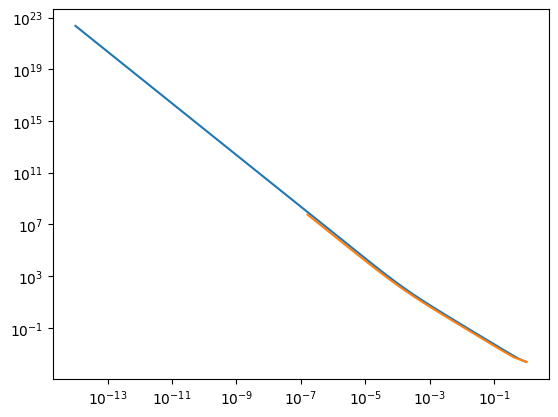

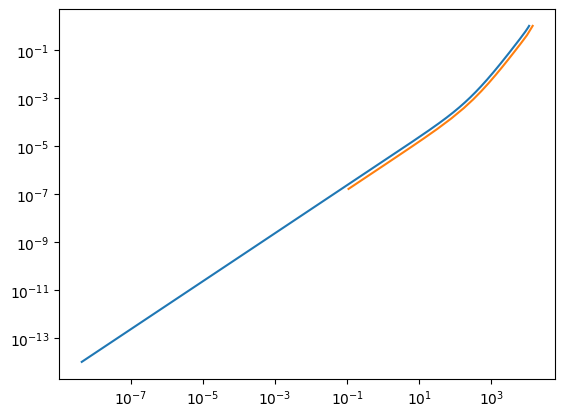

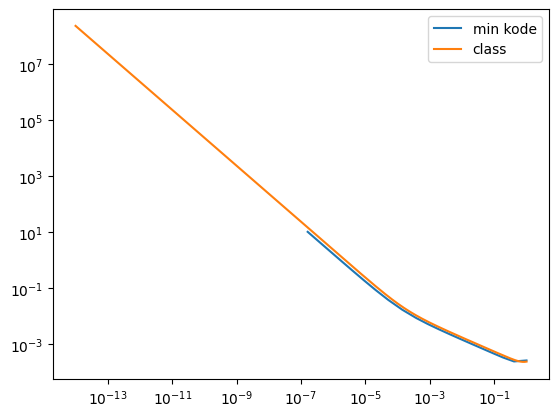

In [88]:
H1 = bg["H [1/Mpc]"]
#print(H)
a1 = 1/(1 + bg['z'])
pts0.keys()
#pts0['tau [Mpc]']
plt.loglog(a1,H1)
plt.loglog(a,H(a))
#plt.xlim([1e-6,1e-4])
plt.figure(1341)
print(bg.keys())
plt.loglog(bg['conf. time [Mpc]'],a1)
plt.loglog(tau,a)
plt.figure(123123123)
plt.loglog(a,a*H(a)*1.1,label="min kode")

plt.loglog(a1,a1*H1,label="class")
plt.legend()